### 1. 决策树（decision tree）的概念

决策树也是机器学习中的一个重要算法，但是我们可能平时在决策的时候就常常用到，比如以下天气和怎么出行的问题：
![example](https://www.sqlshack.com/wp-content/uploads/2019/09/sample-of-a-decision-tree.png)

决策树是一种非参数学习算法，可以解决分类（包括多分类）问题，还可以解决回归问题。

如下的例子，用iris简单看一下决策树。

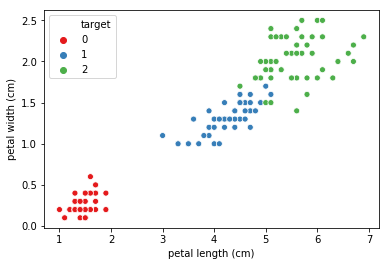

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets

iris = datasets.load_iris()

iris_all = pd.DataFrame(data=iris.data, columns=iris.feature_names).copy()
# target = iris.target

iris_all['target'] = iris.target

# 为了方便可视化，仅使用两个特征
iris = iris_all.iloc[:,2:]

sns.scatterplot(data=iris, x = iris.columns.values[0], y = iris.columns.values[1],hue='target',palette="Set1")
plt.show()

In [3]:
# 决策边界函数
def plot_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    
    h = .02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(4, 3))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Set3_r)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Accent)
    plt.show()

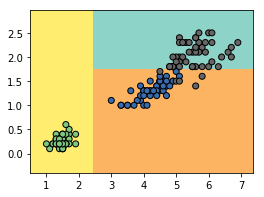

In [4]:
from sklearn.tree import DecisionTreeClassifier

np.random.seed(2)
iris = datasets.load_iris()
X = iris.data[:,2:]
y = iris.target

dt_clf = DecisionTreeClassifier(max_depth=2, criterion='entropy',) # max_depth 最大深度；criterion选择熵
dt_clf.fit(X, y)

plot_boundary(dt_clf, X, y)


以上其实就是一个决策树，当x<2.4时，被分为黄色的一类；其余再进行判断，如果y<1.8，则是橘色的一类, y>1.8则是青色的一类。



---

### 2. 信息熵（information entropy）

在决策树中，每个节点在哪里划分，是如何确定呢？

信息熵是一种判断方法。熵是信息论中衡量随机变量不确定度的，这个值越大则数据的不确定性越高；反之，越小则数据的不确定性越低。信息熵是度量样本集合纯度最常用的一个指标，假如当前样本集合D中第i类样本所占的比例为$p_i$,则D的信息熵为：

\begin{equation}
H = -\sum_{i=1}^{k}p_klog_2p_i 
\end{equation}

假如有一个集合，有三类样本，比例分别为 $\{\frac{1}{3},\frac{1}{3},\frac{1}{3}\}$ ，那么可求得信息熵为：

\begin{equation}
H = -\frac{1}{3}log_2\left(\frac{1}{3}\right)-\frac{1}{3}log_2\left(\frac{1}{3}\right)-\frac{1}{3}log_2\left(\frac{1}{3}\right)=1.585
\end{equation}

假如还有另一个集合，三个分类比例为 $\{\frac{1}{10},\frac{2}{10},\frac{7}{10}\}$ ，则信息熵为：

\begin{equation}
H = -\frac{1}{10}log_2\left(\frac{1}{10}\right)-\frac{2}{10}log_2\left(\frac{2}{10}\right)-\frac{7}{10}log_2\left(\frac{7}{10}\right)=1.157
\end{equation}

第二个集合比第一个集合的信息熵要小。第一个集合的比例都一致，更不确定哪个分类。

假如集合分类是 $\{1,0,0\}$ ,那么信息熵可求得为0.

当仅有两个分类时，一个分类的比例为x,则另一个则为1-x，那么公式为：

\begin{equation}
H = -xlog_x\left(x\right) - \left(1-x\right)log\left(1-x\right) 
\end{equation}

可视化为：

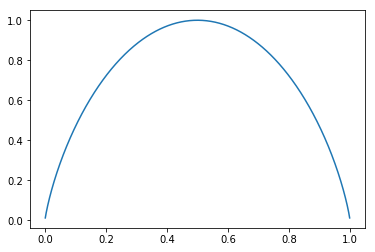

In [5]:
def entropy(p):
    return -p * np.log2(p) - (1-p) * np.log2(1-p)

x = np.linspace(0.001, 0.999, 1000)
plt.plot(x, entropy(x))
plt.show()

### 3. 信息增益

在信息熵概念之后，还有条件熵，即在某一条件X下，Y的信息熵。而信息增益指的就是信息熵-条件熵(Ent(D)即上面的H)，著名的ID3决策树算法就是以信息增益为准则来划分属性的。

\begin{equation}
Gain\left(D,\alpha\right) = Ent\left(D\right) - \sum_{v=1}^{V}\frac{|D_v|}{|D|}Ent\left(D_v\right)
\end{equation}

西瓜书的例子，西瓜数据集包括17训练样本，在根节点中，好瓜有8/17，而坏瓜有9/17；则信息熵为：

\begin{equation}
Ent\left(D\right) = -\left(\frac{8}{17}log_2\frac{8}{17} + \frac{9}{17}log_2{9}{17}\right)=0.998
\end{equation}

在子集D”色泽“属性中，有三个可能的取值：{青绿、乌黑、浅白}，分别记为$D^1$, $D^2$, $D^3$; 其中$D^1$好瓜有3/6，坏瓜有3/6，$D^2$中好瓜有4/6,坏瓜有2/6；$D^3$中好瓜有1/5，坏瓜有4/5，这三个分支节点的信息熵为：

\begin{equation}
Ent\left(D^1\right) = -\left(\frac{3}{6}log_2\frac{3}{6} + \frac{3}{6}log_2{3}{6}\right)=1
Ent\left(D^2\right) = -\left(\frac{4}{6}log_2\frac{4}{6} + \frac{2}{6}log_2{2}{6}\right)=0.918
Ent\left(D^3\right) = -\left(\frac{1}{5}log_2\frac{1}{5} + \frac{4}{5}log_2{4}{5}\right)=0.722
\end{equation}

根据上式可得到信息增益为：

\begin{equation}
Gain\left(D,色泽\right) = 0.998 - \left(\frac{8}{17}\times\ 1 + \frac{6}{17} \times 0.918 + \frac{5}{17} \times 0.722 \right) = 0.109
\end{equation}

然后我们同样可以计算出”纹理“、”敲声“等的信息增益，最终找到信息增益最大的特征，作为划分属性。

---


### 4. 基尼系数（Gini）

对于CART决策树，基尼系数是另外一种判断方法，其公式为：

\begin{equation}
G = 1-\sum_{i=1}^{k}p_i^2
\end{equation}

同样是像上面的三个例子，它们的基尼系数分别为：

\begin{equation}
G1 = 1-\left(\frac{1}{3}\right)^2-\left(\frac{1}{3}\right)^2-\left(\frac{1}{3}\right)^2 = 0.66\\
G2 = 1-\left(\frac{1}{10}\right)^2-\left(\frac{2}{10}\right)^2-\left(\frac{7}{10}\right)^2 = 0.46\\
G3 = 0
\end{equation}

与上面类似，当基尼系数为0时，分类是确定的。当仅有两个分类时，一个分类的比例为x,则另一个则为1-x，那么公式为：

\begin{equation}
G = 1-x^2-\left(1-x\right)^2=-2x^2+2x
\end{equation}

这个抛物线的对称轴也是1/2，在1/2时，信息熵为0，分类最不确定。



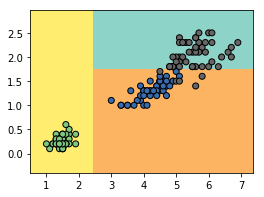

In [6]:
from sklearn.tree import DecisionTreeClassifier

np.random.seed(2)
iris = datasets.load_iris()
X = iris.data[:,2:]
y = iris.target

dt_clf = DecisionTreeClassifier(max_depth=2, criterion='gini') # 改成gini系数 
dt_clf.fit(X, y)

plot_boundary(dt_clf, X, y)


### 5. 调整参数


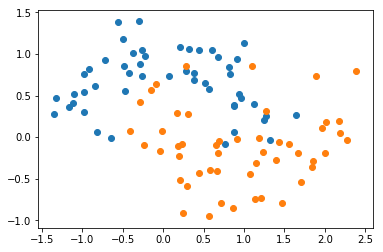

In [10]:
X, y = datasets.make_moons(noise = 0.25, random_state=666)
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

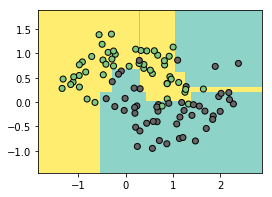

In [11]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X,y)
plot_boundary(dt_clf, X, y)

可以看到明显的过拟合现象。

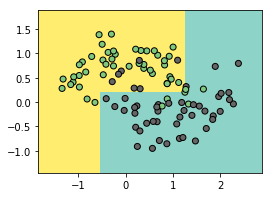

In [12]:
dt_clf2 = DecisionTreeClassifier(max_depth=2)
dt_clf2.fit(X,y)
plot_boundary(dt_clf2, X, y)

In [ ]:
当我们限制深度的时候，可以看到没有过拟合现象了，不过这种情况可能存在欠拟合现象。所以需要调整一下相关的参数。

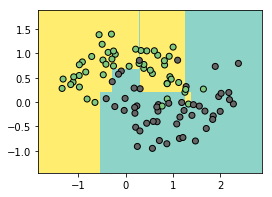

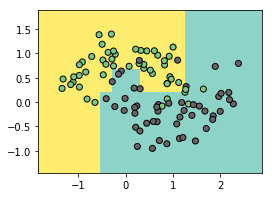

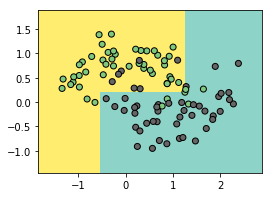

In [15]:
# min_samples_split
# 对于一个节点，至少需要多少样本数据
# 这个参数越大时，则越不容易发生过拟合，不过过大可能会发生欠拟合

dt_clf3 = DecisionTreeClassifier(min_samples_split=10)
dt_clf3.fit(X,y)
plot_boundary(dt_clf3, X, y)

dt_clf3 = DecisionTreeClassifier(min_samples_split=20)
dt_clf3.fit(X,y)
plot_boundary(dt_clf3, X, y)

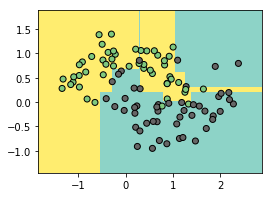

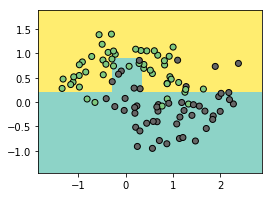

In [18]:
# min_samples_leaf
# 对于叶子节点至少有几个样本
# 这个值越大也是可以避免过拟合

dt_clf4 = DecisionTreeClassifier(min_samples_leaf=1)
dt_clf4.fit(X,y)
plot_boundary(dt_clf4, X, y)

dt_clf4 = DecisionTreeClassifier(min_samples_leaf=6)
dt_clf4.fit(X,y)
plot_boundary(dt_clf4, X, y)




---

### 5. 决策树的局限性

1. 通过上面的图我们都可以看出来，决策树的边界是横平竖直的。可能在分类的时候造成错误。
2. 对个别数据很敏感（这也是所有的非参数学习的缺点）。